G5: Jakober, Winkler, Matzinger, Salzmann

# Multilayer Perceptron from CIFAR10 raw data using PyTorch

## Importing packages

In [2]:
# First, import pytorch, get its version and check available device.

import torch
print('Your torch version is {}'.format(torch.__version__))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

Your torch version is 2.6.0+cu118


device(type='cuda')

In [1]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # for evaluating results
from tqdm.notebook import tqdm # for progress bars

from torch import nn
from torch.optim import Adam
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torchsummary import summary

%matplotlib inline

## Downloading CIFAR dataset
Pytorch provides a set of pre-loaded datasets including CIFAR. We will convert our CIFAR images into tensors when loading them. There are lots of other transformations that you can do using torchvision.transforms like Reshaping, normalizing, etc. on your images but we won't need that since CIFAR is a very primitive dataset.


In [3]:
Transform = transforms.ToTensor() # let us convert cifar data to tensors
train_data = datasets.CIFAR10(
    root = 'data', # path to save cifar10 data
    train = True,                         
    transform = Transform, 
    download = True,            
)

test_data = datasets.CIFAR10(
    root = 'data', 
    train = False, 
    transform = Transform,
    download = True
)

## Printing train_data and test_data

In [4]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

## Visualization of CIFAR10 dataset


Size: torch.Size([3, 32, 32]) Label: 6


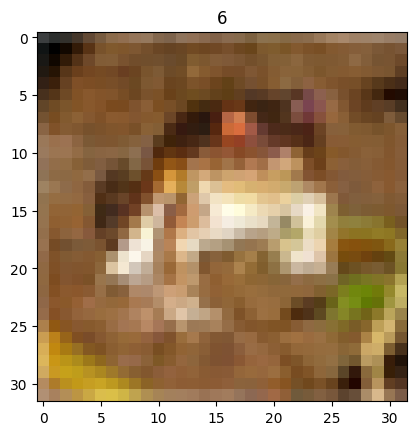

In [6]:
#Plot one train_data
img, target = train_data[0]
print('Size:', img.size(), 'Label:', target)
plt.imshow(img.permute(1, 2, 0)) # to fix the TypeError: Invalid shape (3, 32, 32) for image data
plt.title('%i' % target)
plt.show()

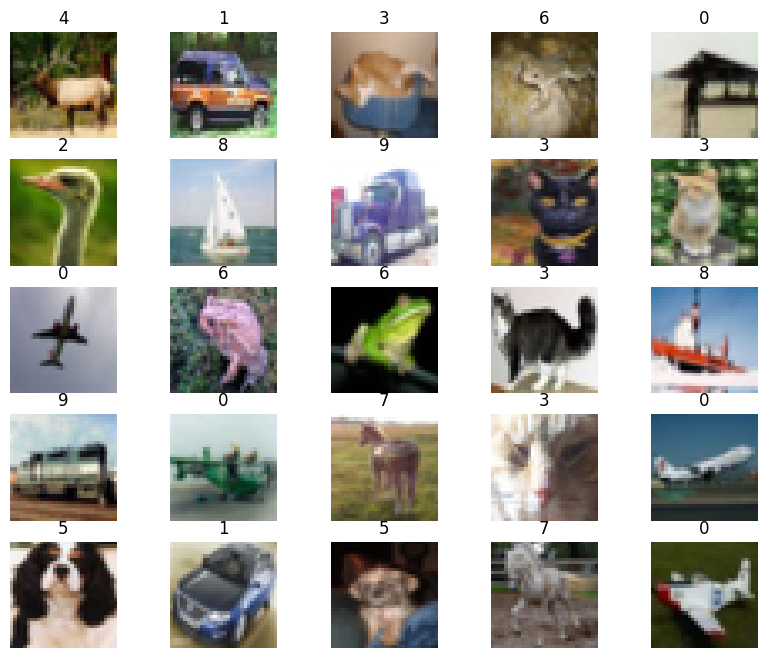

In [7]:
# Plot multiple train_data
def show_imgs(X):
    figure = plt.figure(figsize=(10, 8))
    cols, rows = 5, 5
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(X), size=(1,)).item()
        img, label = X[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.title(label)
        plt.axis("off")
        plt.imshow(img.permute(1,2,0))
    plt.show()
    
show_imgs(train_data)

## Preparing data for training

In [8]:
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

# One-layer network and weight visualisation
## Building the Network

- The code is straightforward. In Pytorch there isn't any implementation for the input layer, the input is passed directly into the first hidden layer. However, you'll find the InputLayer in the Keras implementation.

- The number of neurons in the hidden layers and the number of hidden layers is a parameter that can be played with, to get a better result.

In [9]:
input_dim = 32*32*3

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 10)

    def forward(self, x):
        x = x.view(-1, input_dim)
        # Softmax gets applied in the CrossEntropyLoss. With the softmax here, we obtain
        # a vanishing gradient and the model does not learn anything
        return self.fc1(x)

model = Net().to(device)

criterion = nn.CrossEntropyLoss()
# use Adam as optimizer
lr = 0.001
optimizer = Adam(model.parameters(), lr=lr)

In [10]:
summary(model, (32,32,3))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]          30,730
Total params: 30,730
Trainable params: 30,730
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 0.12
Estimated Total Size (MB): 0.13
----------------------------------------------------------------


## Training and evaluating the Model

Our model is now ready to be trained. Let's define functions to train() and validate() the model.

In [12]:
def train(epoch, model, data_loader, log_interval=200, l2_norm=False, verbose=True):
    
    # ... Set model to training mode
    model.train()
    total_train_loss = 0
    total_correct = 0

    # Loop over each batch from the training set
    for batch_idx, (X_train, y_train) in enumerate(tqdm(data_loader, desc=f"Training Epoch {epoch}", disable=not verbose)):
        # Copy data to GPU if needed
        X_train = X_train.to(device)
        y_train = y_train.to(device)

        optimizer.zero_grad()
        output = model(X_train)
        
        # Calculate loss
        loss = criterion(output, y_train)

        if l2_norm:
            loss += 0.05 * sum(p.norm(2) for p in model.parameters())

        # Back-propagate
        loss.backward()
        
        # Update weights
        optimizer.step()

        total_train_loss += loss.item()

        _, y_pred = torch.max(output, dim=1)
        total_correct += torch.sum(y_pred == y_train).item()

        if batch_idx % log_interval == 0 and verbose:
            print(f'Train Epoch: {epoch} [{batch_idx * len(X_train)}/{len(data_loader.dataset)} ({100. * batch_idx / len(data_loader):.0f}%)]\tLoss: {loss.data.item():.6f}')
    
    accuracy_train = total_correct / len(data_loader.dataset)
    total_train_loss = total_train_loss / len(data_loader)

    return {
        "loss": total_train_loss,
        "accuracy": accuracy_train,
    }

In [13]:
# torch.inference_mode() disables certain features that are not required
# for inference, such as autograd and other tracking.
# It's optional, but improves performance.
# Alternative: @torch.no_grad(), which only disables autograd. 
@torch.inference_mode()

def validate(model, data_loader, verbose=True):
    model.eval()

    val_loss = 0
    total_correct = 0
    total_preds = []
    total_targets = []

    for X_val, y_val in tqdm(data_loader, desc="Validation", disable=not verbose):
        X_val = X_val.to(device)
        y_val = y_val.to(device)
        output = model(X_val)
        val_loss += criterion(output, y_val).item()
        
        _, y_pred = torch.max(output, dim=1)
        total_correct += torch.sum(y_pred == y_val).item()
        total_preds.append(y_pred.detach().cpu())
        total_targets.append(y_val.cpu())

    val_loss /= len(data_loader)
    accuracy = total_correct / len(data_loader.dataset)

    if verbose:
        print(f"\nValidation set: Average loss: {val_loss:.4f}, Accuracy: {total_correct}/{len(data_loader.dataset)} ({100 * accuracy:.2f}%)\n")
    
    return {
        "loss": val_loss,
        "accuracy": accuracy,
        "predictions": torch.cat(total_preds),
        "targets": torch.cat(total_targets),
    }

Now we are ready to train our model using the train() function. An epoch means one pass through the whole training data. After each epoch, we evaluate the model using validate().

In [14]:
%%time

epochs = 5

# Keep track of stats to plot them
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(1, epochs + 1):
    train_result = train(epoch, model, train_loader, l2_norm=False, verbose=False)
    train_losses.append(train_result["loss"])
    train_accuracies.append(train_result["accuracy"])
    
    val_result = validate(model, test_loader, verbose=False)
    val_losses.append(val_result["loss"])
    val_accuracies.append(val_result["accuracy"])

CPU times: total: 30.3 s
Wall time: 32.6 s


## Loss and Accuracy evaluation during training

Let's now visualize how the training progressed.

Loss is a function of the difference of the network output and the target values. We are minimizing the loss function during training so it should decrease over time.
Accuracy is the classification accuracy for the test data.

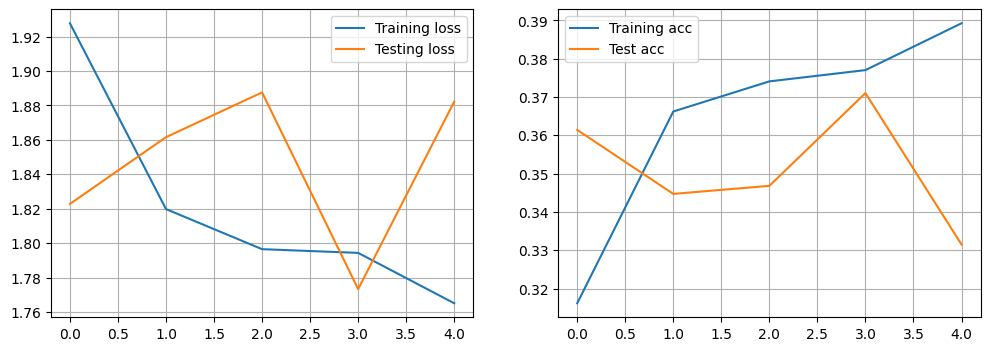

In [15]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(train_losses, label='Training loss')
ax1.plot(val_losses, label='Testing loss')
ax1.legend()
ax1.grid()

ax2.plot(train_accuracies, label='Training acc')
ax2.plot(val_accuracies, label='Test acc')
ax2.legend()
ax2.grid()

# Comments
Model learns something during training, but fails to generalize on unseen data, because with an MLP we do not consider the 2D-Structure of an image and lose important structural information.

### Confusion matrix


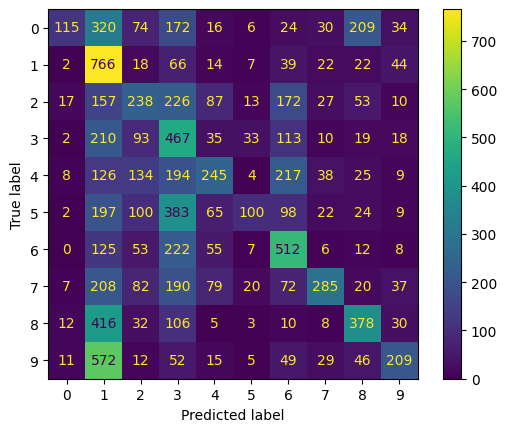

In [16]:
# val_result is from the validation of the last epoch above.
# But you could run it specifically with:
#
# val_result = validate(model, test_loader)

cm = confusion_matrix(val_result["targets"], val_result["predictions"])

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

### Plot the weights
The weights connected to a given neuron, when using a one-layer network, have the same shape as the input. They can therefore be plot. To do so we need to re-scale the weight values into 0-255 pixel values.

Weight of classification layer has size: torch.Size([10, 3072])


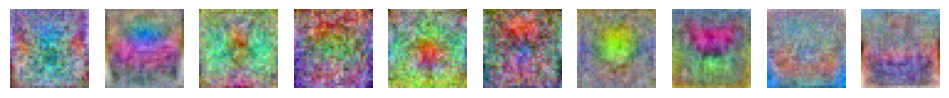

In [17]:
# The weight of the classification layer
classifier_weight = model.fc1.weight.detach().cpu()

print(f"Weight of classification layer has size: {classifier_weight.size()}")

fig = plt.figure(figsize=(12,12))

for i, weight in enumerate(classifier_weight):
    ax = fig.add_subplot(1, 10, 1+i)
    # now put back the pixel values to 0-255 doing a min-max norm and multiplying by 255
    min_value = min(weight)
    max_value = max(weight)
    im = (weight - min_value) / (max_value - min_value) * 255
    ax.axis('off')

    im = im.reshape(3, 32, 32).permute(1, 2, 0)

    ax.imshow(im.int())

# Two Layers


In [23]:
class Net(nn.Module):
    def __init__(self, hidden_dim=128, num_layers = 1):
        super().__init__()
        self.input_dim = 32*32*3

        layers = [nn.Linear(self.input_dim, hidden_dim), nn.ReLU()]

        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())

        layers.append(nn.Linear(hidden_dim, 10))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.network(x)

model = Net().to(device)

criterion = nn.CrossEntropyLoss()
# use Adam as optimizer
lr = 0.001
optimizer = Adam(model.parameters(), lr=lr)

In [24]:
summary(model, (32,32,3))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         393,344
              ReLU-2                  [-1, 128]               0
            Linear-3                   [-1, 10]           1,290
Total params: 394,634
Trainable params: 394,634
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 1.51
Estimated Total Size (MB): 1.52
----------------------------------------------------------------


In [25]:
%%time

epochs = 30

# Keep track of stats to plot them
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in tqdm(range(1, epochs + 1), desc="Epoch"):
    train_result = train(epoch, model, train_loader, l2_norm=True, verbose=False)
    train_losses.append(train_result["loss"])
    train_accuracies.append(train_result["accuracy"])

    val_result = validate(model, test_loader, verbose=False)
    val_losses.append(val_result["loss"])
    val_accuracies.append(val_result["accuracy"])

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

CPU times: total: 3min 15s
Wall time: 3min 28s


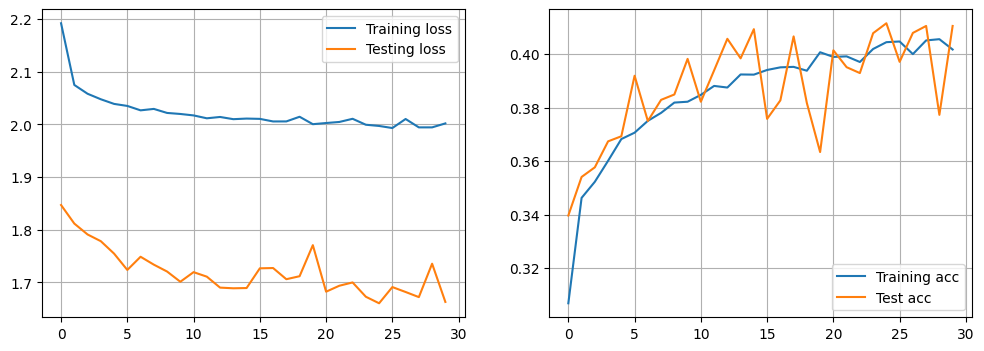

In [26]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.plot(train_losses, label='Training loss')
ax1.plot(val_losses, label='Testing loss')
ax1.legend()
ax1.grid()

ax2.plot(train_accuracies, label='Training acc')
ax2.plot(val_accuracies, label='Test acc')
ax2.legend()
ax2.grid()

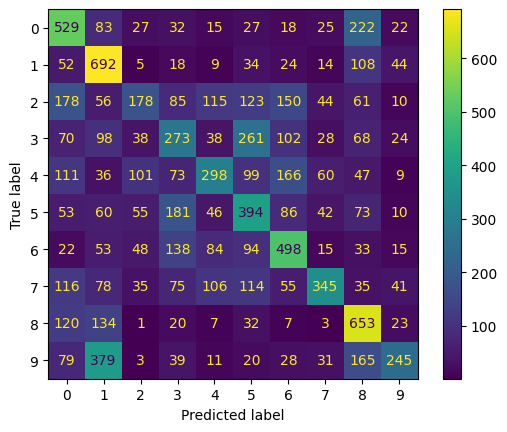

In [27]:
cm = confusion_matrix(val_result["targets"], val_result["predictions"])

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Comments:
Already better results, than before with no hidden layers, however, still a lot of false predictions. In the next cell we try out some other configurations with additional hidden layers or a larger size of those layers.

Run 1 with hidden-dim: 128, 20 epochs and 2 fully-connected Layers


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Run 1 Validation-Metrics: Loss: 1.7200721185418624, Accuracy: 0.383
Run 2 with hidden-dim: 128, 20 epochs and 4 fully-connected Layers


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Run 2 Validation-Metrics: Loss: 2.0888911470582214, Accuracy: 0.1805
Run 3 with hidden-dim: 256, 20 epochs and 1 fully-connected Layers


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Run 3 Validation-Metrics: Loss: 1.653062728386891, Accuracy: 0.4161
Run 4 with hidden-dim: 256, 20 epochs and 2 fully-connected Layers


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Run 4 Validation-Metrics: Loss: 1.7896788286257395, Accuracy: 0.3378
Run 5 with hidden-dim: 256, 20 epochs and 4 fully-connected Layers


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Run 5 Validation-Metrics: Loss: 2.077370251281352, Accuracy: 0.1852


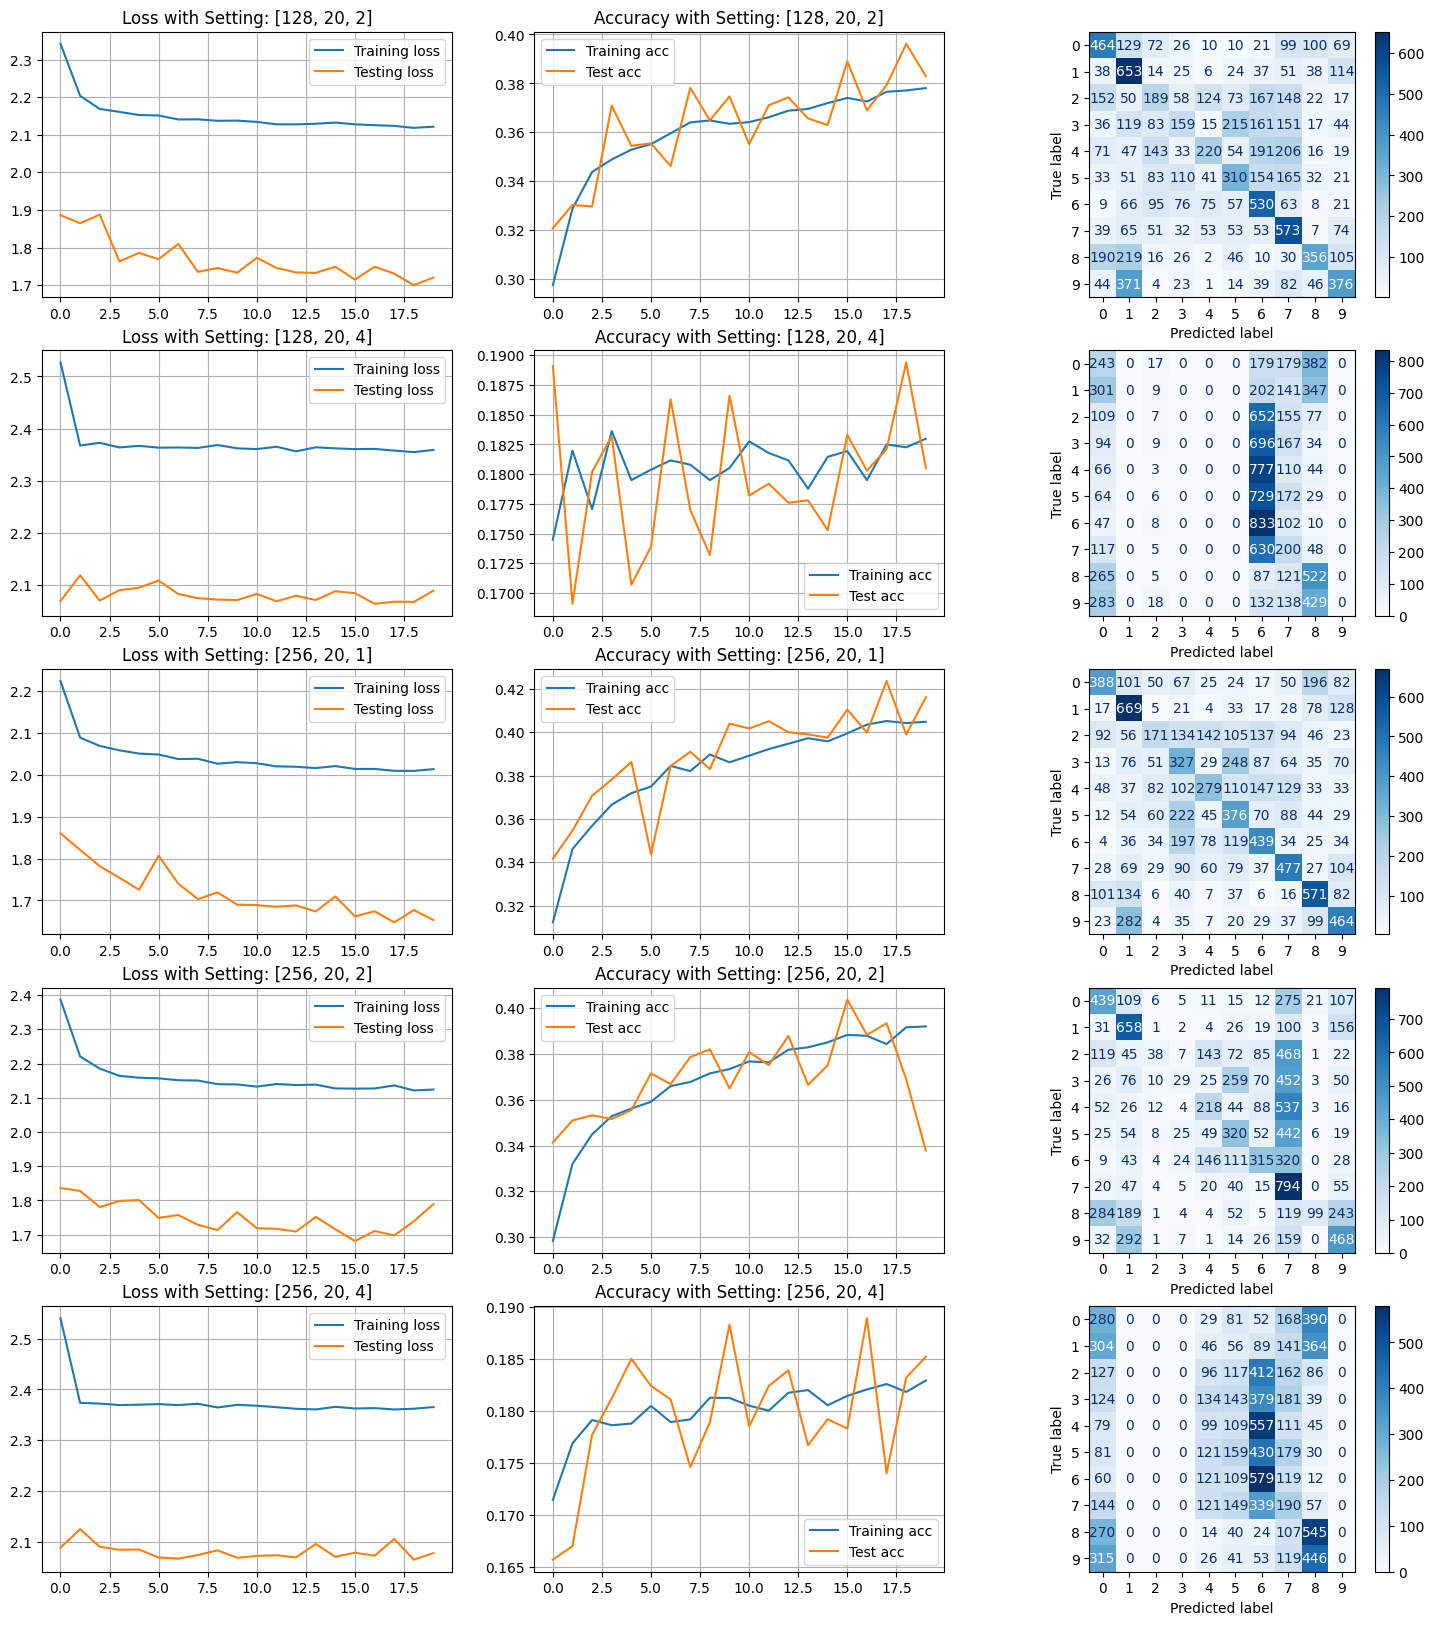

In [59]:
# Settings: Hidden-Dim, Epochs, Num Layers

settings = [
    [128, 20, 2],
    [128, 20, 4],
    [256, 20, 1],
    [256, 20, 2],
    [256, 20, 4],
]

criterion = nn.CrossEntropyLoss()

fig, axes = plt.subplots(len(settings), 3, figsize=(18, 4 * len(settings)))

for i, setting in enumerate(settings):
    print(f"Run {i+1} with hidden-dim: {setting[0]}, {setting[1]} epochs and {setting[2]} fully-connected Layers")
    hidden_dim, epochs, num_layers = setting
    model = Net(hidden_dim, num_layers).to(device)

    lr = 0.001
    optimizer = Adam(model.parameters(), lr=lr)

    # Keep track of stats to plot them
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in tqdm(range(1, epochs + 1), desc="Epoch"):
        train_result = train(epoch, model, train_loader, l2_norm=True, verbose=False)
        train_losses.append(train_result["loss"])
        train_accuracies.append(train_result["accuracy"])

        val_result = validate(model, test_loader, verbose=False)
        val_losses.append(val_result["loss"])
        val_accuracies.append(val_result["accuracy"])

    print(f"Run {i+1} Validation-Metrics: Loss: {val_losses[-1]}, Accuracy: {val_accuracies[-1]}")

    axes[i, 0].plot(train_losses, label='Training loss')
    axes[i, 0].plot(val_losses, label='Testing loss')
    axes[i, 0].set_title(f"Loss with Setting: {setting}")
    axes[i, 0].legend()
    axes[i, 0].grid()

    axes[i, 1].plot(train_accuracies, label='Training acc')
    axes[i, 1].plot(val_accuracies, label='Test acc')
    axes[i, 1].set_title(f"Accuracy with Setting: {setting}")
    axes[i, 1].legend()
    axes[i, 1].grid()

    cm = confusion_matrix(val_result["targets"], val_result["predictions"])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axes[i, 2], cmap="Blues")

plt.show()

## Comments
Across models with max. 2 Layers, a steady improvement over the epochs is visible.
However, more layers do not seem to improve the performance, as the model does not seem to learn anything anymore.
A larger hidden dimension does also not seem to improve the performance. It seems that the performance ceiling of such models that neglect the 3D structure of color images has been reached. We need to see if we can improve these metrics with CNN.
